In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boston/calendar.csv
/kaggle/input/boston/reviews.csv
/kaggle/input/boston/listings.csv


### Background:

This Notebook is an analysis about Boston Airbnb Open Data in Kaggle: https://www.kaggle.com/airbnb/boston

The following Airbnb activity is included in this Boston dataset:

* Listings, including full descriptions and average review score
* Reviews, including unique id for each reviewer and detailed comments
* Calendar, including listing id and the price and availability for that day

## Questions to explore:
* What are the busiest times of the year to visit Boston? By how much do prices spike?
* Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Boston?
* Can we predict the price of listings?


In [2]:
### read all the files
listings=pd.read_csv('../input/boston/listings.csv')
reviews=pd.read_csv('../input/boston/reviews.csv')
calendar=pd.read_csv('../input/boston/calendar.csv')

### Data Exploration

In [3]:
### preview the datasets

listings.describe()
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [4]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [5]:
calendar.head()


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

### Data Preprocessing

In [7]:
#### some columns have missing values. Need to transform data type for price for modeling purpose. 

#### Drop columns that have more than 80% null value

#### Since there're 95 variables in the dataset, I create a subset to have variables I interested in 

In [8]:
### Drop columns that have more than 80% null value
null_80=listings.columns[listings.isnull().mean()>0.8]
listings.drop(columns=null_80)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,10.0,9.0,9.0,f,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,9.0,10.0,f,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,10.0,10.0,f,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,9.0,10.0,f,f,flexible,f,f,1,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,8373729,https://www.airbnb.com/rooms/8373729,20160906204935,2016-09-07,Big cozy room near T,5 min walking to Orange Line subway with 2 sto...,NaN,5 min walking to Orange Line subway with 2 sto...,none,NaN,...,10.0,8.0,9.0,f,t,strict,f,f,8,0.34
3581,14844274,https://www.airbnb.com/rooms/14844274,20160906204935,2016-09-07,BU Apartment DexterPark Bright room,"Most popular apartment in BU, best located in ...",Best location in BU,"Most popular apartment in BU, best located in ...",none,NaN,...,NaN,NaN,NaN,f,f,strict,f,f,2,NaN
3582,14585486,https://www.airbnb.com/rooms/14585486,20160906204935,2016-09-07,Gorgeous funky apartment,Funky little apartment close to public transpo...,Modern and relaxed space with many facilities ...,Funky little apartment close to public transpo...,none,"Cambridge is a short walk into Boston, and set...",...,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN
3583,14603878,https://www.airbnb.com/rooms/14603878,20160906204935,2016-09-07,Great Location; Train and Restaurants,"My place is close to Taco Loco Mexican Grill, ...",NaN,"My place is close to Taco Loco Mexican Grill, ...",none,NaN,...,9.0,8.0,7.0,f,f,strict,f,f,1,2.00


In [9]:
# make a copy of the dataset
df=listings.copy()

In [10]:
# clean the data with money involved
# df['price']=df['price'].map(lambda p: int(p[1:-3].replace(",", "")))

# price=[]
# for p in df['price']:
#     p=p[1:-3].replace(",", "")
#     price.append(p)

def clean_price(column):
    result=[p[1:-3].replace(",","")for p in column]
    return result




In [11]:
# clean the price column
df['price']=clean_price(df['price'])

# clean the security_deposit column
df['security_deposit']=df['security_deposit'].fillna('$0.00')

df['security_deposit']=clean_price(df['security_deposit'])

#clean extra_people column
df['extra_people']=clean_price(df['extra_people'])

# clean the cleaning_fee column
df['cleaning_fee']=df['cleaning_fee'].fillna('$0.00')
df['cleaning_fee']=clean_price(df['cleaning_fee'])

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [12]:

# After removing the "$" sign, we need to change the money related data type to numeric

df['security_deposit']=df['security_deposit'].astype(float)
df['price']=df['price'].astype(float)
df['cleaning_fee']=df['cleaning_fee'].astype(float)
df['extra_people']=df['extra_people'].astype(float)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

Now we clean the prices, we can answer some questions

# 1. Busiest times of the year to visit Boston & prices spike

In [14]:
# The businest time should have fewer vacancies so we can graph the availability with calendar table
calendar.head()
calendar.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [15]:
# when there's no availability(f), price is NaN
#clean the price for calendar table


In [16]:

calendar[calendar['available']!='f']
notnull_calendar=calendar[calendar['price'].notnull()]

notnull_calendar['clean_price']=[int (p[1:-3].replace(",", "")) for p in notnull_calendar['price']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
notnull_calendar.head()
notnull_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 365 to 1308879
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   listing_id   643037 non-null  int64 
 1   date         643037 non-null  object
 2   available    643037 non-null  object
 3   price        643037 non-null  object
 4   clean_price  643037 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 29.4+ MB


Text(0.5, 1.0, 'Average price of Airbnb in Boston')

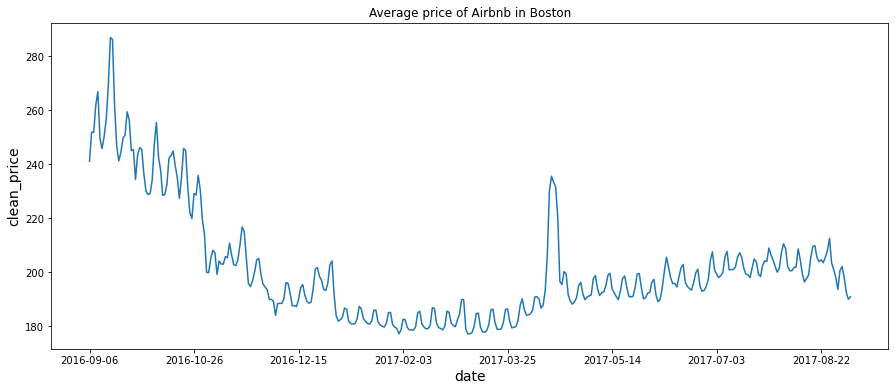

In [18]:
import matplotlib.pyplot as plt

# create figure and axis objexts with subplots()
fig,ax=plt.subplots(figsize=(15,6))

# make a plot
notnull_calendar.groupby('date')['clean_price'].mean().plot()

#set x-axis label
ax.set_xlabel("date",fontsize=14)

# set y-axis label
ax.set_ylabel("clean_price",fontsize=14)

# set title
ax.set_title('Average price of Airbnb in Boston')


### Findings:
* prices are high from Sep to begining of Oct but in a decreasing trend. It might because the supply was increasing during the time
* A spike happened around Mid Apr
* It seems there's a seasonale fluctuation of the price,this may be correspond to weekend

Text(0.5, 1.0, 'Boston Airbnb Availability')

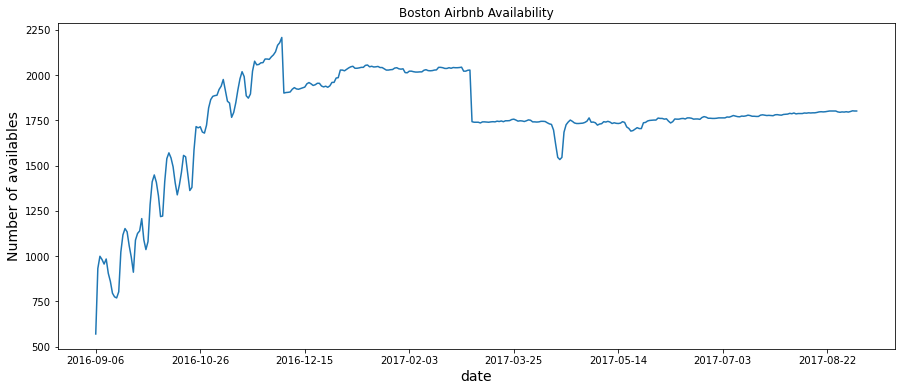

In [19]:
# plot the availability
fig,ax2=plt.subplots(figsize=(15,6))

# make a plot
notnull_calendar.groupby('date')['available'].count().plot()

# set x-axis lable
ax2.set_xlabel("date", fontsize=14)

# set y-axis label
ax2.set_ylabel("Number of availables", fontsize=14)

# set the title label
ax2.set_title("Boston Airbnb Availability")

### Findings
* The higest demand for Boston Airbnb happened on Sep. As demand increases, the price decreases. 
* The supply had a big drop in Feb but the price remained stable

# 2. Airbnb business trend in Boston


In [20]:
num_host=df.groupby('host_since')[['id']].count()

# rename the column
num_host=num_host.rename({'id':'num_hosts'}, axis='columns')

# get the accumulative number of houses

num_host['acc_host']=num_host['num_hosts'].cumsum()


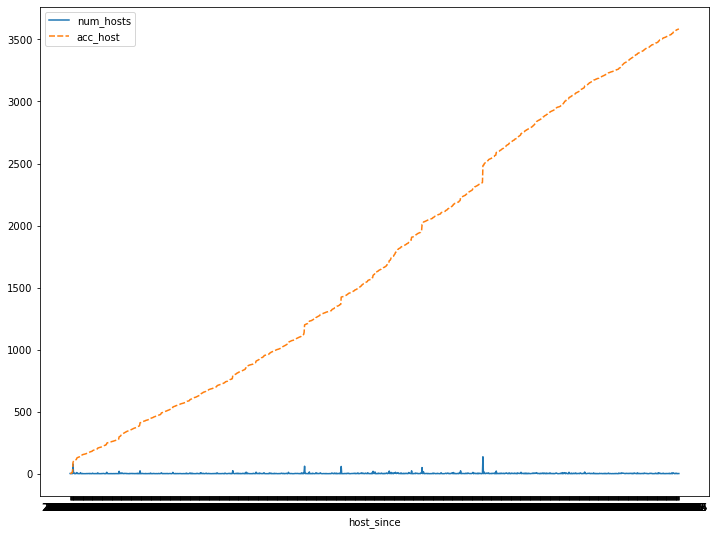

In [21]:
num_host.head()

# graph to see the trend
f,ax=plt.subplots(figsize=(12,9))
sns.lineplot(data=num_host)

### Findings
* We can see the slope of the graph increases

### Listing Trend of Neighborhood

In [22]:
# create a column since_month to show listing started month
df['since_month']= [d[0:7] for d in df['host_since']]

In [23]:
# get the number of hosts by neighborhood
neigh_host=df.groupby(['since_month','neighbourhood_cleansed'])[['id']].count().groupby("neighbourhood_cleansed").cumsum()

# rename the column
neigh_host=neigh_host.rename({"id":"num_host"},axis='columns')

# sort table 
neigh_host.sort_values(by=['neighbourhood_cleansed','since_month'])

neigh_host

num_host
since_month neighbourhood_cleansed          
2008-11     Allston                        2
2008-12     East Boston                    1
2009-02     Jamaica Plain                  1
            Roxbury                        7
2009-05     Roslindale                     1
...                                      ...
2016-09     Dorchester                   269
            Downtown                     172
            East Boston                  150
            Jamaica Plain                343
            South End                    326

[1019 rows x 1 columns]

In [24]:
# reset index
neigh_host.reset_index(inplace=True)
neigh_host

,since_month,neighbourhood_cleansed,num_host
0,2008-11,Allston,2
1,2008-12,East Boston,1
2,2009-02,Jamaica Plain,1
3,2009-02,Roxbury,7
4,2009-05,Roslindale,1
...,...,...,...
1014,2016-09,Dorchester,269
1015,2016-09,Downtown,172
1016,2016-09,East Boston,150
1017,2016-09,Jamaica Plain,343


In [25]:
# pivot the table from rows to columns
neigh_host_wide=neigh_host.pivot(index='since_month',columns='neighbourhood_cleansed',values='num_host')

In [26]:
# some since_month don't have record. Assume it means there's no new host in the month
# impute previous data to fill NaN
neigh_host_wide=neigh_host_wide.fillna(method='ffill')
# fill remaining with 0
neigh_host_wide=neigh_host_wide.fillna(0)

In [27]:
neigh_host_wide

neighbourhood_cleansed,Allston,Back Bay,Bay Village,Beacon Hill,Brighton,Charlestown,Chinatown,Dorchester,Downtown,East Boston,...,Mattapan,Mission Hill,North End,Roslindale,Roxbury,South Boston,South Boston Waterfront,South End,West End,West Roxbury
since_month,,,,,,,,,,,,,,,,,,,,,
2008-11,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-12,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
2009-05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0
2009-07,2.0,28.0,0.0,6.0,0.0,0.0,4.0,0.0,17.0,1.0,...,0.0,6.0,0.0,1.0,7.0,0.0,1.0,8.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05,246.0,292.0,23.0,184.0,164.0,105.0,66.0,254.0,164.0,140.0,...,22.0,116.0,137.0,55.0,141.0,170.0,80.0,314.0,48.0,42.0
2016-06,255.0,294.0,23.0,187.0,170.0,107.0,66.0,259.0,164.0,143.0,...,22.0,118.0,141.0,55.0,143.0,170.0,81.0,320.0,48.0,43.0
2016-07,257.0,299.0,23.0,191.0,177.0,108.0,69.0,263.0,169.0,147.0,...,22.0,122.0,143.0,56.0,144.0,171.0,82.0,322.0,48.0,44.0


In [28]:
# reset index
neigh_host_wide.reset_index(inplace=True)
# melted the dataframe for visulization
neigh_host_long=pd.melt(neigh_host_wide, id_vars=['since_month'])

In [29]:
# rename columns
neigh_host_long=neigh_host_long.rename({"neighbourhood_cleansed":"neighbourhood","value":"cum_host"}, axis='columns')

In [30]:
# sort the dataframe
neigh_host_long.sort_values(by='cum_host', ascending=False)

,since_month,neighbourhood,cum_host
1143,2016-09,Jamaica Plain,343.0
1142,2016-08,Jamaica Plain,342.0
1141,2016-07,Jamaica Plain,340.0
1140,2016-06,Jamaica Plain,340.0
1139,2016-05,Jamaica Plain,334.0
...,...,...,...
1760,2008-11,South Boston,0.0
1761,2008-12,South Boston,0.0
1762,2009-02,South Boston,0.0
1763,2009-05,South Boston,0.0


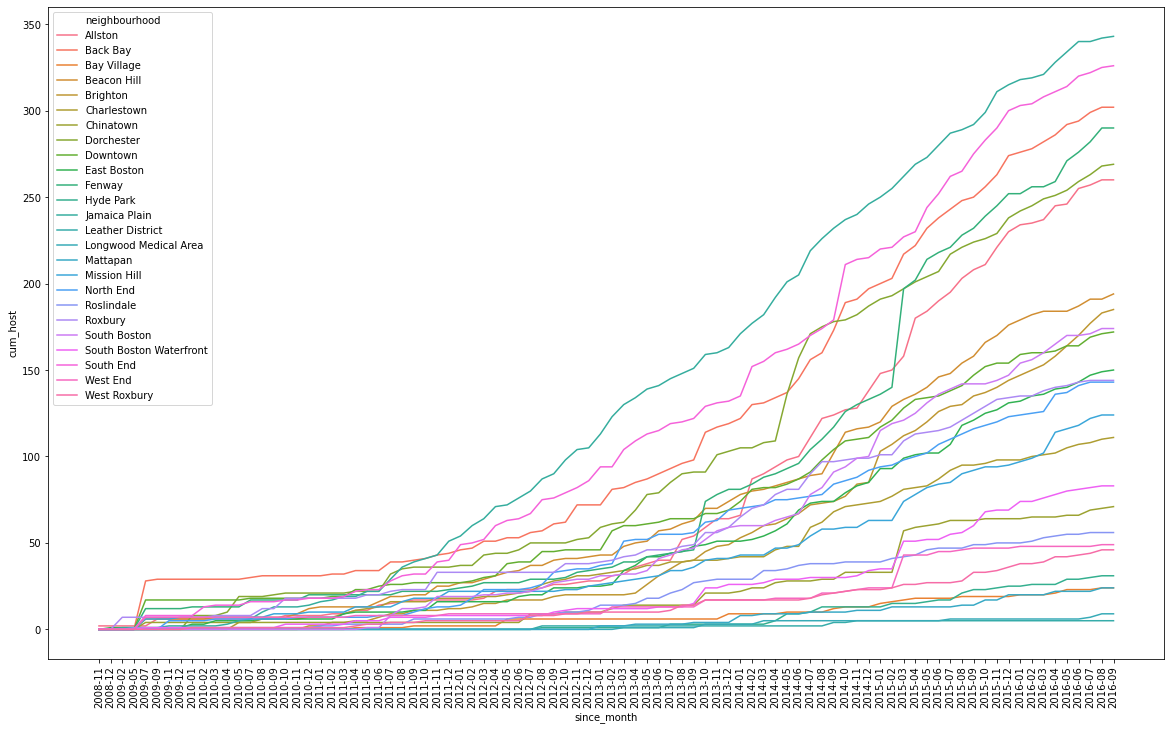

In [31]:
# plot the data
f, ax = plt.subplots(figsize=(20, 12))
g=sns.lineplot(data=neigh_host_long, x="since_month", y='cum_host', hue='neighbourhood')
g=g.set_xticklabels(neigh_host_long.since_month.unique(),rotation=90)

### Findings

* Jamaica Plain has the most hosts among the neighbourhoods
* Some neighbourhood doesn't grow to much in turns of numbers of host over the year
* Some neighbourhood had sharp increase in number of hosts around early 2015
